In [ ]:
from IPython.display import display, Math, Latex

# Libraries you might need
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np
import seaborn as sns

In [ ]:
# You can use this function for plotting raster plots (spikes), or you can use your own defined function
def raster(event_times_list, color='k', t_min= 0., t_max=10., ax=None):
    """
    Creates a raster plot
    Parameters
    ----------
    event_times_list : iterable
                       a list of event time iterables
    color : string
            color of vlines
    Returns
    -------
    ax : an axis containing the raster plot
    https://scimusing.wordpress.com/2013/05/06/making-raster-plots-in-python-with-matplotlib/
    """
    if ax is None:
        ax = plt.gca()
    for ith, trial in enumerate(event_times_list):
        ax.vlines(trial, ith + .5, ith + 1.5, color=color)
    ax.set_ylim(.5, len(event_times_list) + .5)
    ax.set_yticks([])
    ax.set_ylabel('Spike train')
    ax.set_xlim((t_min, t_max))
    ax.set_xlabel('Time [s]')
    return ax

### Homework 2

__1. Generation of inhomogeneous Poisson process__. Consider an inhomogeneous Poisson process with instanteneous firing rate $\lambda: \mathbb{R} \to \mathbb{R}^+$ such that $\lambda(t) = \lambda_{max} (t-1)^2$, where $t$ is measured in seconds, $\lambda$ in Herz [Hz].

In exercise (a) - (d), generate $N = 100$ spike trains for $\lambda_{max} = 100$ Hz. Plot the raster plot, the numeric approximation of the rate and for comparison the analytic rate given in the exercise.
A numeric approximation of the rate $\tilde\lambda$ can be computed by binning the data into 100 bins on the interval $[t_{min}, t_{max}]$ for each spike train (bin size $\Delta t = \frac{t_{max}-t_{min}}2$) and computing the number of spikes in all spike trains within the bin, devided by $N$ and the bin size: $\tilde\lambda = \frac{\#spikes}{N \cdot \Delta t}$.

*Hint: Compute the analytical integral of the rate function. Write a function both for the rate function and its integral.*

In [ ]:
def rate(t, rate_max):
    return rate_max * (t-1)**2

def indefinite_integral(t, rate_max):
    return rate_max * 1/3 * (t-1)**3

def rate_integral(t_min, t_max, rate_max):
    return indefinite_integral(t_max, rate_max) - indefinite_integral(t_min, rate_max)

rate_max = 100
n_trials = 100
t_min = 0
t_max = 2
bins_count = np.linspace(t_min, t_max, 101)
bin_size = bins_count[1] - bins_count[0]

__a) Temporal distribution method:__ As in the lecture: first find number of spikes $k$ by drawing from Poisson distribution with parameter $\mu = \int_{t_{min}}^{t_{max}} \lambda(t) dt $, and then draw spike times using a density function $\lambda(t)/\mu$. _(2 points)_

*Hint: Choose an appropriate method for drawing from an arbitrary probability density, e.g., rejection sampling.*

In [ ]:
# compute
# --- sample number of spikes
# calculate mu
mu = rate_integral(t_min, t_max, rate_max)
# draw spike-counts k from Poisson
spike_counts = np.random.poisson(lam=mu, size=n_trials)


def F(t):
    return rate(t, rate_max) / mu


# helper distrbution function : uniform on [0, 2]
def G(t):
    return 0.5 * ((t < 2.0) & (t > 0.0))


# draw a F distributed random number
def draw_F():
    while True:
        # sample from helper distribution
        t = np.random.uniform(0.0, 2.0)
        # sample constant to compare
        c = np.random.uniform()
        # reject or accept
        if (F(t) / (3.0 * G(t))) > c:
            return t


# --- rejection sample spike times
# distribution to sample from
spike_times_tdm = []

# iterate 100 runs
for k in spike_counts:
    # draw k numbers from F
    spike_times = np.array([draw_F() for _ in range(k)])
    spike_times_tdm.append(spike_times)

# bin into intervals and compute lambda_bar for each
hist, bin_edges = np.histogram(np.concatenate(spike_times_tdm), bins=bins_count)
hist = hist / (n_trials * bin_size)
x = (bin_edges[1:] + bin_edges[:-1]) / 2

<matplotlib.legend.Legend>

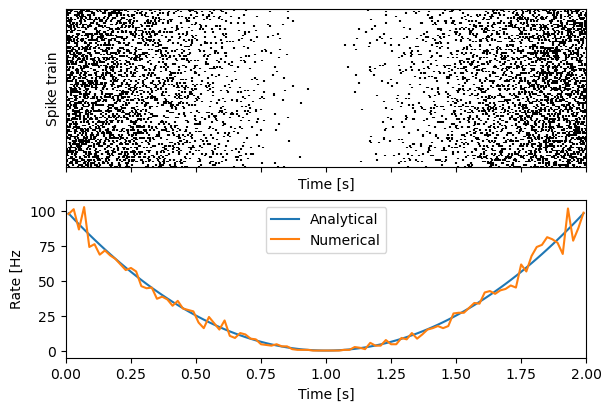

In [ ]:
# plot
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1, figsize=(6, 4), layout="constrained", sharex=True, sharey=False
)

raster(spike_times_tdm, t_max=2, ax=ax1)
ax2.plot(x, rate(x, rate_max), label="Analytical")
ax2.plot(x, hist , label="Numerical")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Rate [Hz")
ax2.legend(loc="upper center")

__b) Bernoulli method:__ Discretize time into $m$ bins. For each bin $j = 1, \ldots, m$ draw a sample $k_i$ from a Poisson spike count distribution in that bin ( Poisson distribution with the parameter equal to integral of the $\lambda(t)$ over the bin). Generate a single spike in each bin with $k_i > 0$ drawing its time-stamp from uniform distribution within this bin. Generate rasters and estimated rate for $m = 10, \: 100, \: 1000, \: 10000.$ _(2 points)_

*Note: The bin count for computing a numerical approximation of the rate is still the same as above.*

In [ ]:
# compute
def bernoulli_method(m):
    time_bin_edges = np.linspace(0.0, 2.0, num=m + 1)
    time_bin_size = time_bin_edges[1] - time_bin_edges[0]

    spike_times_all = []
    # N = 100
    for _ in range(n_trials):
        spike_times = []
        # iterate bins
        for i in range(m):
            # draw a sample k_i
            mu = rate_integral(time_bin_edges[i], time_bin_edges[i + 1], rate_max)
            if np.random.poisson(lam=mu):
                # genereate spike in bin if k_i > 0
                spike_times.append(time_bin_size * i + np.random.uniform(0, time_bin_size))
                
        spike_times = np.array(spike_times)
        spike_times_all.append(spike_times)

        # bin into intervals and compute lambda_bar for each
        hist, bin_edges = np.histogram(np.concatenate(spike_times_all), bins = bins_count)
        hist = hist / (n_trials * bin_size)
        x = (bin_edges+0.01)[1:]

    return spike_times_all, hist, x

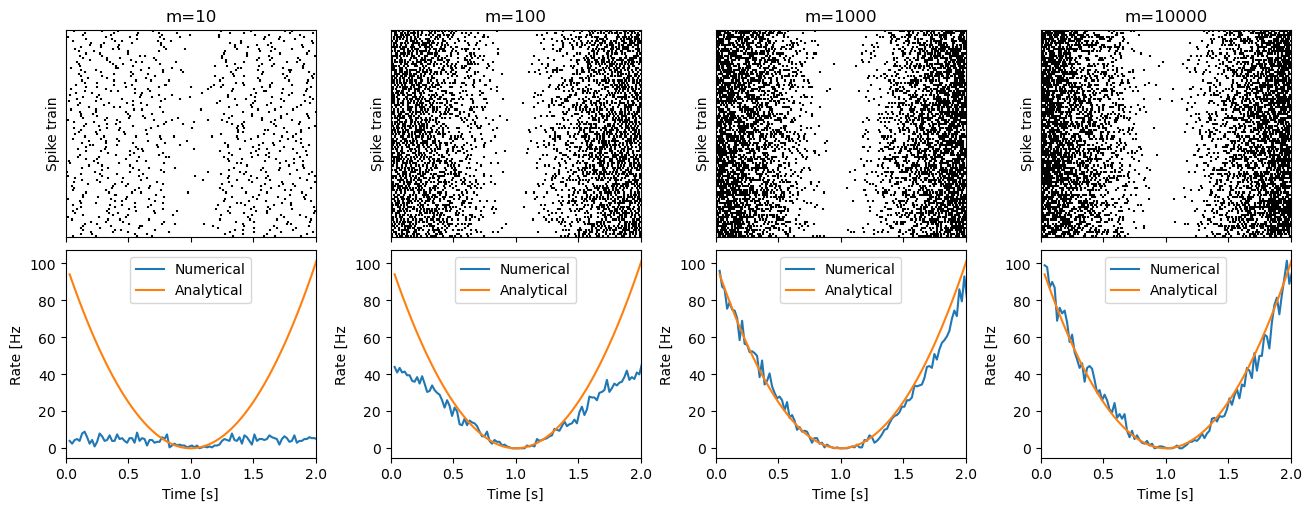

In [ ]:
# plot
fig, axes = plt.subplots(
    nrows=2, ncols=4, figsize=(13, 5), layout="constrained", sharex=True, sharey=False
)

for m, ax1, ax2 in zip([10, 100, 1000, 10000], axes[0], axes[1]):
    spike_times, hist, x = bernoulli_method(m)
    raster(spike_times, t_max=2, ax=ax1)

    ax1.set_title(f"m={m}")
    ax1.set_xlabel("")
    ax2.plot(x, hist, label="Numerical")
    ax2.plot(x, rate(x, rate_max), label="Analytical")
    ax2.set_xlabel("Time [s]")
    ax2.set_ylabel("Rate [Hz")
    ax2.legend(loc="upper center")

plt.show()

__c) Thinning method:__ First generate a spike train from a Poisson process of rate $\lambda_{max}$ and then iterate through all spikes $l = 1, \ldots, k$ and randomly delete them with probability $1 - \lambda(t^\star_l) /\lambda_{max}$, where $t^\star_l$ is a time point of the $l$-th spike (before thinning). _(2 points)_

In [ ]:
# compute
spike_times_all = []

for _ in range(n_trials):
    # generate spike train
    k = np.random.poisson(lam=rate_max * 2)
    spikes = np.sort(np.random.uniform(0.0, 2.0, size=k))
    spike_times = []
    for t in spikes:
        # delete spike
        if np.random.binomial(n=1, p=1 - rate(t, rate_max) / rate_max):
            pass
        # don't delete spike
        else:
            spike_times.append(t)
    spike_times = np.array(spike_times)
    spike_times_all.append(spike_times)

# bin into intervals and compute lambda_bar for each
hist, bin_edges = np.histogram(np.concatenate(spike_times_all), bins=bins_count)
hist = hist / (n_trials * bin_size)
x = (bin_edges[1:] + bin_edges[:-1]) / 2


<matplotlib.legend.Legend>

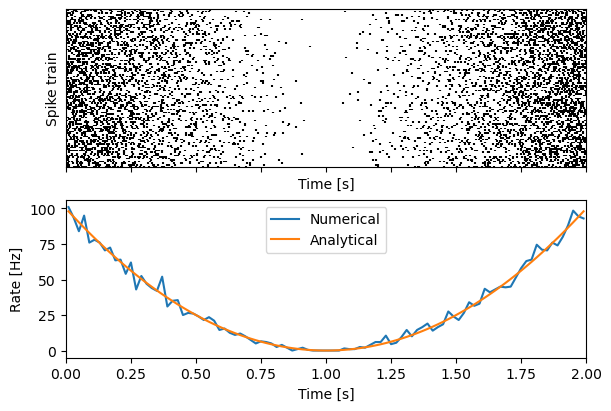

In [ ]:
# plot
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1, figsize=(6, 4), layout="constrained", sharex=True, sharey=False
)

raster(spike_times_all, t_max=2, ax=ax1)
ax2.plot(x, hist, label="Numerical")
ax2.plot(x, rate(x, rate_max), label="Analytical")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Rate [Hz]")
ax2.legend(loc="upper center")

__d) Renewal and time rescaling method:__ Compute $\mu(t) = \int_{t_{min}}^t \lambda(s) ds$. Generate a spike train for a homogeneous Poisson process with rate $1$ on an interval $[0,\mu(t_{max})]$ (using inter-spike interval distribution as in the previous homework). Resulting spike times we call $s_l^\star$. We can then find corresponding pre-images $t_l^\star = \mu^{-1}(s_l^\star) \in [t_{min},t_{max}].$ _(2 points)_

Hint: Options for inverting functions:
- Invert $\mu(t)$ analytically and write a function. Of course, you can use any tools that you want. Remember to write your solution concisely including necessary intermediate steps.*
- You can also use "sympy" library to create symbolic equations and then find the inverse function using those symbolic equations _(2 points)_
- To find the inverse of a polynomial function at a specific value you can use function np.roots (https://docs.scipy.org/doc/numpy/reference/generated/numpy.roots.html ). You will need a real root within the interval $[t_{min},t_{max}]$.

**Answer:**

TODO

In [ ]:
# compute
def poisson_spike_train_simple(tau, length, n_trials):
    all_spike_times = []
    for _ in range(n_trials):
        t = np.random.exponential(tau)
        spike_times = []
        while t < length:
            spike_times = spike_times + [t]
            t += np.random.exponential(tau)
        all_spike_times.append(np.array(spike_times))

    return all_spike_times

def mu_inv(s):
    return np.cbrt(3 / rate_max * s - 1) + 1


spike_times_all = []
for _ in range(n_trials):
    # upper bound for interval
    mu_tmax = rate_integral(0, t_max, rate_max)
    # sample homogeneous Poisson
    s = poisson_spike_train_simple(tau=1.0, length=mu_tmax, n_trials=1)[0]

    # calculate the inverse values for s* to get the t*
    spike_times = mu_inv(s)
    spike_times_all.append(spike_times)

# bin into intervals and compute lambda_bar for each
hist, bin_edges = np.histogram(np.concatenate(spike_times_all), bins=bins_count)
hist = hist / (n_trials * bin_size)

x = (bin_edges[1:] + bin_edges[:-1]) / 2

<matplotlib.legend.Legend>

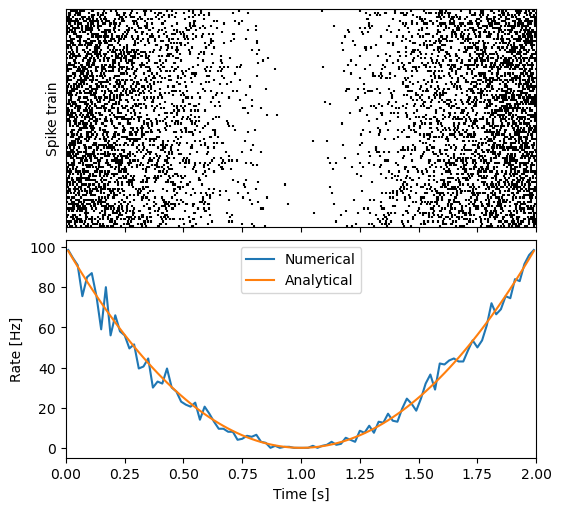

In [ ]:
# plot
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1, figsize=(5.5, 5), layout="constrained", sharex=True, sharey=False
)

raster(spike_times_all, t_max=2, ax=ax1)
ax1.set_xlabel("")
ax2.plot(x, hist, label="Numerical")
ax2.plot(x, rate(x, rate_max), label="Analytical")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Rate [Hz]")
ax2.legend(loc="upper center")

__2. Variance of the firing rate a)__. Determine the variance of the firing rate (across the bins) using $b = 10, \: 50, \:100$ bins from spike trains generated by method 1.a) using the law of total variance  _(2 points)_

**Answer:**

Formulas I need...

In [ ]:
def total_variance(n_bins):
    spike_counts = np.array(list(map(lambda x: x.size, spike_times_tdm)))
    data = np.array([np.histogram(trial, bins=n_bins)[0] for trial in spike_times_tdm])
    m = spike_counts.mean()
    v = data.var()
    del_t = 2 / n_bins
    total_var = v / del_t**2 - m / (2.0 * del_t)
    print("n_bin=", m)
    print("mean spike counts =", m)
    print("var of spike counts =", v)
    print("var of firing rate =", total_var)
    print("-----------------")

In [ ]:
total_variance(10)
total_variance(50)
total_variance(100)

n_bin= 66.09
mean spike counts = 66.09
var of spike counts = 41.00811899999999
var of firing rate = 859.9779749999997
-----------------
n_bin= 66.09
mean spike counts = 66.09
var of spike counts = 2.79264476
var of firing rate = 919.277975
-----------------
n_bin= 66.09
mean spike counts = 66.09
var of spike counts = 1.02791119
var of firing rate = 917.527975
-----------------


TODO calculate var of firing rate

__2. Variance of the firing rate b)__. Compare results from 2.a) with analytical variance of the rate. To compute the analytical variance use the true formula for the time-dependent rate $\lambda(t) = \lambda_{max} (t-1)^2$ and treat it as a random variable for the time $t$ uniformly distributed in $[t_{min},t_{max}]$. \\
_(2 points)_

\begin{equation*}
\begin{split}
Var(\lambda)
&= ... \\
&= \lambda_{max}^2 \frac4{45}\\
&= 888.89
\end{split}
\end{equation*}

In [ ]:
# see pdf for solution